In [ ]:
####################################################################################
'''
Importing Libraries

1. Scientific functions:

    a) numpy
    b) scipy
    c) JAX (GPU)

2. Plotting:

    a) matplotlib

3. Just-In-Time compilation : JAX
'''
####################################################################################

import scipy as sc
import torch as torch

import numpy as np
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
import seaborn

import pathlib,json,os,time


import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm


jax.config.update('jax_enable_x64', True) # Set float-64 as a Default variable type.

In [ ]:
####################################################################################
'''
Setting up and Mounting Google Drive for saving data
'''
####################################################################################
from google.colab import drive
drive.mount('/content/drive')



# Define path to your folder in Google Drive for initial condition
folder_path_init = '/content/drive/MyDrive/2D_Burgers_stochastic'

# Define path to your folder in Google Drive for saving Lagrangian Dynamics Data
folder_path = '/content/drive/MyDrive/2D_Burgers_stochastic_wrapped_Run_6'

# Create the folder if it does not exist
os.makedirs(folder_path, exist_ok=True)

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Nov  9 06:45:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

# General Parameters

In [ ]:
####################################################################################
'''
General definitions and set-up
'''
####################################################################################

pi = np.pi
N = 2**11 # No. of collocation points
L = 2*pi   # Domain length

dx = L/N

linear_array = jnp.linspace(0, L, N+1)[:-1]  # 1D mesh grid in real-space

mesh_grid = jnp.stack(jnp.meshgrid(linear_array, linear_array, indexing='ij')) # 2D meshgrid


dt = 1e-3           # step size
T_final = 1000   #Final time

save_interval = 2   # frequency of saving data

steps = int(save_interval/dt) + 1
T_final_steps = int(T_final/save_interval)

t = np.arange(0, T_final, save_interval)

nu = 5e-4   # Viscosity

# tau_p = jnp.array([0.02, 0.1, 0.5, 2, 6, 10, 20, 40, 60, 80, 100, 200]) # RUN 1
# tau_p = jnp.array([0.8,1,4,8,15,25,30,50,70,90,120,500])                # RUN 2
# tau_p = jnp.array([0.25, 3 ,5 , 7 ,9 ,12 ,14 , 16, 17, 19 , 23 ,27])      # RUN 3
# tau_p = jnp.array([0.7,1.25, 1.5 , 1.75, 2.5 ,3.5  , 4.5 ,5.5 ,6.5 ,7.5 , 8.5, 9.5 ])      # RUN 4
# tau_p = jnp.linspace(8/6.25,35/6.25, 12)  # RUN 5
tau_p = jnp.linspace(2/6.25,8/6.25, 12, endpoint = False)  # RUN 6


print(tau_p)
####################################################################################
'''
Fourier Modes, Derivative operator And Cut-off for Spectral method
'''
####################################################################################

k_x = jnp.fft.fftfreq(N, d=L/N) * 2*pi
k_y = jnp.fft.rfftfreq(N, d=L/N) * 2*pi

k_vec = jnp.stack(jnp.meshgrid(k_x, k_y, indexing='ij'))                        # 2D Fourier-space Mesh-grid

derivative_operator = 1j * k_vec                                                # Derivative operator D = \iota \vec{k}

laplacian = -jnp.sum(k_vec**2, axis=0)                                          # \nabla^2 = -|k|^2

k_over_lapacian = jnp.where( laplacian == 0 , 0 , k_vec/(-1*laplacian) )        # \vec{k}/|k|^2. for the projection onto curl-free sector

k_UV_cutoff = N//4
UV_cutoff = (jnp.sqrt(-laplacian) <= k_UV_cutoff) * 1.0                         # UV-cutoff in Fourier space

alias_mask = (jnp.sqrt(-laplacian) <= N//3) * 1.0  # Dealias Mask



shells = jnp.arange(-0.5,N//2)
shells = shells.at[0].set(0)

####################################################################################
'''
Forcing in spectral space
'''
####################################################################################

beta = 2   # Power of covarianve of Forcing
D0 = 60     # Amplitude of the Forcing


force_amp_OU = D0*UV_cutoff*jnp.where(laplacian == 0, 0, jnp.sqrt(-laplacian)**(-beta/2)) # Total forcing amplitude with proper time-stepping multiplied for OU_process

force_amp = jnp.sqrt(dt)*D0*UV_cutoff*jnp.where(laplacian == 0, 0, jnp.sqrt(-laplacian)**(-beta/2)) # Total forcing amplitude with proper time-stepping multiplied.


# For Ornstien-Uhlembeck proces

theta = jnp.eye(2)            # Charecteristic time scales for both the components
sigma = jnp.eye(2)*0.05       # Covarianve Matrix for the forcing.


####################################################################################
'''
Initial Condition in spectral space
'''
####################################################################################

u_0 = jnp.load(os.path.join(folder_path_init, f'Velocity_field_{19}.npz'))['v_spec']

####################################################################################
'''
Semi-Group operators for IFRK4 method.
'''
####################################################################################

# Fixed linear operator calculation

linear_operator = nu * laplacian  # Laplacian is already negative

SemiG = jnp.exp(linear_operator * dt)
SemiG_Half = jnp.exp(linear_operator * dt / 2)

[0.32 0.4  0.48 0.56 0.64 0.72 0.8  0.88 0.96 1.04 1.12 1.2 ]


# Seting up: Initial Condition for Lagrangian Particles:

In [ ]:
####################################################################################
'''
Initialize particles
'''
####################################################################################

N_particles = 2**20

seed_1 = int(time.time_ns() % (2**32 - 1))
key_1 = jax.random.PRNGKey(seed_1)

pos = jax.random.uniform(key_1, (N_particles, 2)) * L
pos =  pos*jnp.ones((len(tau_p),N_particles,2))


seed_2 = int(time.time_ns()%(2**32 - 1))
key_2 = jax.random.PRNGKey(seed_2)

v =  2*(jax.random.uniform(key_2, (N_particles, 2)) - 0.5)
v =  v*jnp.ones((len(tau_p),N_particles,2))


In [ ]:
# Define parameters
params = {
    "N": N,   # Degree of freedom
    "N_p": N_particles,   # Number of particles
    "nu": nu,        # Viscosity
    "L": 2*pi,       # Domain length
    "dt":  dt,       # Time step
    "UV_cutoff": k_UV_cutoff, # UV_cutoff
}

# Define the full path to the JSON file
file_path = os.path.join(folder_path, "parameters.json")

# Write to the JSON file
with open(file_path, "w") as f:
    json.dump(params, f, indent=4)

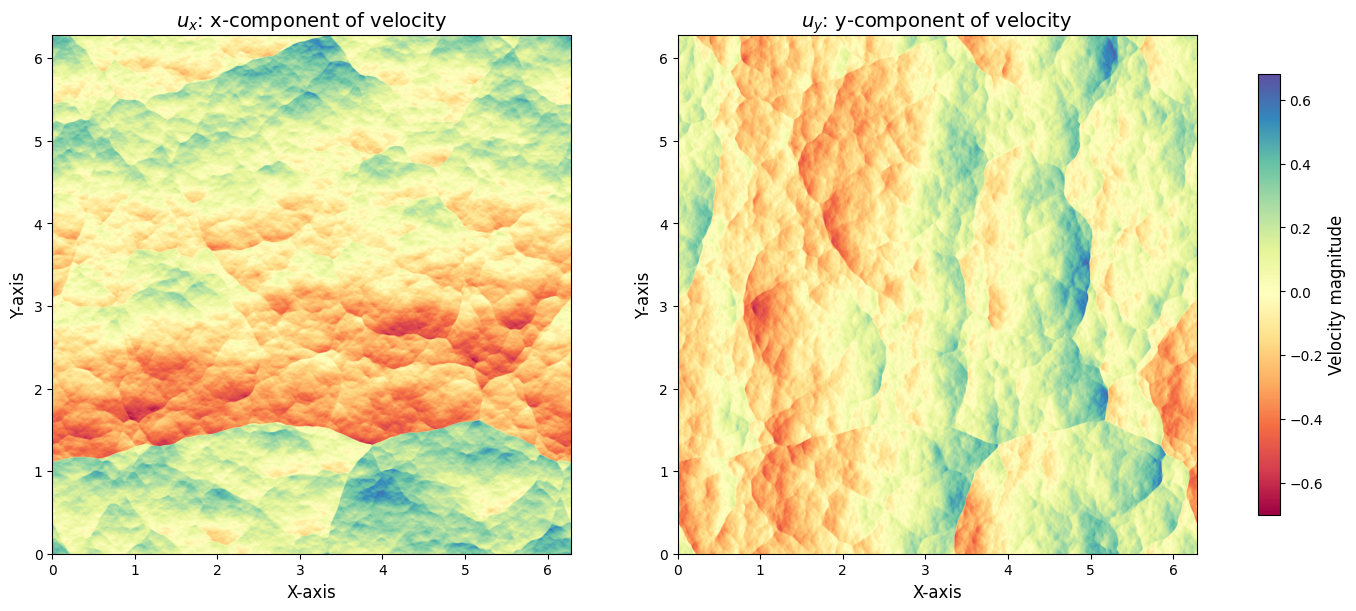

In [ ]:
####################################################################################
'''
Visualization of initial condition
'''
####################################################################################

u_x = jnp.fft.irfft2(u_0[0], norm='ortho')
u_y = jnp.fft.irfft2(u_0[1], norm='ortho')

vmin = min(u_x.min(), u_y.min())
vmax = max(u_x.max(), u_y.max())

f, axarr = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

im0 = axarr[0].imshow(u_x, origin='lower', extent=[0, L, 0, L],
                      cmap='Spectral', vmin=vmin, vmax=vmax)
im1 = axarr[1].imshow(u_y, origin='lower', extent=[0, L, 0, L],
                      cmap='Spectral', vmin=vmin, vmax=vmax)

axarr[0].set_title(r'$u_x$: x-component of velocity', fontsize=14)
axarr[1].set_title(r'$u_y$: y-component of velocity', fontsize=14)

for ax in axarr:
    ax.set_xlabel("X-axis", fontsize=12)
    ax.set_ylabel("Y-axis", fontsize=12)

cbar = f.colorbar(im1, ax=axarr, shrink=0.85, location='right')
cbar.set_label("Velocity magnitude", fontsize=12)
plt.show()

In [ ]:
####################################################################################
'''
Helping Function: 1.curl-free projection, 2.divergence  3.curl
'''
####################################################################################

@jax.jit
def curl_free_projection(u, k_over_lapacian = k_over_lapacian):

  return k_over_lapacian*(jnp.sum(k_vec*u,0))


@jax.jit
def divergence(u):

  return jnp.sum(derivative_operator*u,0)

@jax.jit
def curl(u):

  return jnp.fft.irfft2(derivative_operator[0]*u[1] - derivative_operator[1]*u[0] , norm = 'ortho')

In [ ]:
####################################################################################
'''
Right-hand side computation for Burgers equation
'''
####################################################################################

@jax.jit
def computeRHS(U_spec, derivative_operator=derivative_operator, laplacian=laplacian, nu=nu):

    u = jnp.fft.irfft2(U_spec, axes=[1, 2], norm='ortho')

    u_squared = jnp.sum(u**2, axis=0)

    nonlinear_term = -0.5 * derivative_operator * jnp.fft.rfft2(u_squared, norm='ortho')

    return alias_mask*nonlinear_term

# Lagrangian Evolution

In [ ]:

####################################################################################
'''
Bilinear interpolation function - CORRECTED
'''
####################################################################################

@jax.jit
def interp_velocity_linear(pos, u_field, dx=dx, L=L):

    pos = jnp.asarray(pos)
    u_field = jnp.asarray(u_field)

    N_grid = u_field.shape[1]

    # Wrap positions into [0, L)
    pos_wrapped = jnp.mod(pos, L)

    # Grid coordinates
    gx = pos_wrapped[:, 0] / dx
    gy = pos_wrapped[:, 1] / dx

    # Grid indices
    ix = jnp.floor(gx).astype(jnp.int32) % N_grid
    iy = jnp.floor(gy).astype(jnp.int32) % N_grid

    # Fractional parts
    fx = gx - jnp.floor(gx)
    fy = gy - jnp.floor(gy)

    # Next indices with proper wrapping
    ix1 = (ix + 1) % N_grid
    iy1 = (iy + 1) % N_grid

    # Get velocity components at grid points
    # u_field is (2, N, N), we need (Nprtcl, 2)
    v00_x = u_field[0, ix, iy]    # x-component at (ix, iy)
    v10_x = u_field[0, ix1, iy]   # x-component at (ix+1, iy)
    v01_x = u_field[0, ix, iy1]   # x-component at (ix, iy+1)
    v11_x = u_field[0, ix1, iy1]  # x-component at (ix+1, iy+1)

    v00_y = u_field[1, ix, iy]    # y-component at (ix, iy)
    v10_y = u_field[1, ix1, iy]   # y-component at (ix+1, iy)
    v01_y = u_field[1, ix, iy1]   # y-component at (ix, iy+1)
    v11_y = u_field[1, ix1, iy1]  # y-component at (ix+1, iy+1)

    # Bilinear interpolation weights
    w00 = (1.0 - fx) * (1.0 - fy)
    w10 = fx * (1.0 - fy)
    w01 = (1.0 - fx) * fy
    w11 = fx * fy

    # Interpolated velocities
    vel_x = w00 * v00_x + w10 * v10_x + w01 * v01_x + w11 * v11_x
    vel_y = w00 * v00_y + w10 * v10_y + w01 * v01_y + w11 * v11_y

    return jnp.stack([vel_x, vel_y], axis=1)

# Forcing

In [ ]:
####################################################################################
'''
Defination for Stochastic Forcing
'''
####################################################################################

# OU-process
@jax.jit
def forcing_OU(forcing_field,noise , force_amp = force_amp_OU):

  forcing_field = jnp.reshape(forcing_field, (2,N**2))

  forcing_field = forcing_field - jnp.matmul(theta,forcing_field)*dt  + jnp.matmul(sigma,noise)*jnp.sqrt(dt)

  forcing_field = jnp.reshape(forcing_field, (2,N,N))

  spectral_forcing_field = force_amp*jnp.fft.rfft2(forcing_field, norm="ortho", axes=[1, 2])

  return  curl_free_projection(spectral_forcing_field) , forcing_field


# Deterministic Forcing
@jax.jit
def forcing_deterministic():
  return jnp.stack((
    jnp.fft.rfft2(jnp.sin(2*mesh_grid[0]), norm='ortho'),
    jnp.fft.rfft2(jnp.sin(2*mesh_grid[1]), norm='ortho')))

In [ ]:
####################################################################################
'''
Lagrangian evolution - CORRECTED
'''
####################################################################################

@jax.jit
def Lagrangian_evolution(tracer_pos, u_real, v_tracer , tau_p):

    # Interpolate velocity at tracer positions
    u_interp = interp_velocity_linear(tracer_pos, u_real)

    # Update tracer positions
    tracer_pos = (tracer_pos + dt*v_tracer)%(2*pi)

    # Update tracer velocities (Stokes drag)
    v_tracer = v_tracer + (dt/tau_p)*(u_interp - v_tracer)

    return tracer_pos, v_tracer

In [ ]:
@jax.jit
def IFRK4(u, key, pos, v, sigma=sigma, theta=theta, dt=dt, N=N , tau_p = tau_p):

    key, subkey = jax.random.split(key)
    noise = jax.random.normal(subkey, (2, N, N))

    forcing_field = force_amp*jnp.fft.rfft2(noise, norm="ortho", axes=[1, 2])

    k1 = computeRHS(u)
    k2 = computeRHS(SemiG_Half * (u + 0.5 * dt * k1))
    k3 = computeRHS(SemiG_Half * u + 0.5 * dt * k2)
    k4 = computeRHS(SemiG * u + SemiG_Half * k3 * dt)

    u = SemiG*u + (SemiG*k1 + 2*SemiG_Half*(k2 + k3) + k4)*(dt/6.0)  + curl_free_projection(forcing_field)

    u_real = jnp.fft.irfft2(u, axes=[1, 2], norm='ortho')

    for counter in range(len(tau_p)):

      pos_counter, v_counter = Lagrangian_evolution(pos[counter], u_real, v[counter], tau_p[counter])

      pos = pos.at[counter].set(pos_counter)

      v = v.at[counter].set(v_counter)


    return u, key, pos, v


def body_fun(i, state):
    u, key_repeator, pos, v = state
    u, key_repeator, pos, v = IFRK4(u, key_repeator, pos, v)
    return u, key_repeator, pos, v



@jax.jit
def repeator(u,skip,key_repeator,pos_lag_particle,v_lag_particle,force_amp=force_amp):

    u ,key_repeator,pos_lag_particle,v_lag_particle = jax.lax.fori_loop(0, skip, body_fun, (u,key_repeator,pos_lag_particle,v_lag_particle))

    return u,key_repeator,pos_lag_particle , v_lag_particle

In [ ]:
####################################################################################
'''
Main-Body
'''
####################################################################################

seed = int(time.time_ns() % (2**32 - 1)) # initial seed for stochastic forcing
key_init = jax.random.key(seed)

# Time evolution
for count in tqdm(range(T_final_steps)):

  print(u_0[0,2,3])

  jnp.savez(os.path.join(folder_path, f'Velocity_Particle_Data_{count}.npz'), v_spec = u_0, pos_particle = pos, vel_particle = v)

  u_0 , key_init , pos, v = repeator(u_0,steps,key_init,pos,v)

  0%|          | 0/500 [00:00<?, ?it/s]

(4.348188303135634-0.5477782306351332j)


  0%|          | 1/500 [00:48<6:45:39, 48.78s/it]

(-25.82859579247361-0.4280342349992631j)


  0%|          | 2/500 [01:17<5:04:36, 36.70s/it]

(-26.759717439280816+3.795083519795343j)


  1%|          | 3/500 [01:42<4:22:56, 31.74s/it]

(5.448412163472838+22.479081538777514j)


  1%|          | 4/500 [02:07<4:00:28, 29.09s/it]

(8.784969536458059-6.470740945723254j)


  1%|          | 5/500 [02:32<3:47:26, 27.57s/it]

(7.893875405606876+8.617658997990972j)


  1%|          | 6/500 [02:57<3:39:28, 26.66s/it]

(17.102315958134515-7.588927802630082j)


  1%|▏         | 7/500 [03:22<3:33:27, 25.98s/it]

(1.4664325374657645-21.607862822815278j)


  2%|▏         | 8/500 [03:46<3:28:49, 25.47s/it]

(-0.05815855103033396-2.411071860006989j)


  2%|▏         | 9/500 [04:10<3:25:06, 25.06s/it]

(15.053230612227656-8.16845496065146j)


  2%|▏         | 10/500 [04:34<3:22:23, 24.78s/it]

(27.33961883714043-22.44964230261889j)


  2%|▏         | 11/500 [04:59<3:20:21, 24.58s/it]

(16.06315237426476-21.525808001871507j)


  2%|▏         | 12/500 [05:23<3:18:26, 24.40s/it]

(3.426118209564619-2.2455868813216786j)


  3%|▎         | 13/500 [05:47<3:16:59, 24.27s/it]

(2.5880096561105903+1.4787975555186823j)


  3%|▎         | 14/500 [06:10<3:15:48, 24.17s/it]

(11.890100394547485+2.7458396779287697j)


  3%|▎         | 15/500 [06:34<3:14:29, 24.06s/it]

(-4.6639920673913355-15.426600158957278j)


  3%|▎         | 16/500 [06:58<3:13:19, 23.97s/it]

(-2.7859990391727205+0.004781428697815088j)


  3%|▎         | 17/500 [07:22<3:12:24, 23.90s/it]

(-26.847447504296483-1.5818127045891952j)


  4%|▎         | 18/500 [07:45<3:11:31, 23.84s/it]

(-10.229743518999062+16.828583493160707j)


  4%|▍         | 19/500 [08:09<3:10:46, 23.80s/it]

(-0.16624618969643717+1.5325186222681055j)


  4%|▍         | 20/500 [08:33<3:10:06, 23.76s/it]

(8.516380742709643-29.47731008195219j)


  4%|▍         | 21/500 [08:57<3:09:34, 23.75s/it]

(5.020475419887702-8.021057452874546j)


  4%|▍         | 22/500 [09:20<3:09:02, 23.73s/it]

(-7.413419445916086-1.7913852687933927j)


  5%|▍         | 23/500 [09:44<3:08:31, 23.71s/it]

(4.325635914768387-7.633301457860715j)


  5%|▍         | 24/500 [10:08<3:08:00, 23.70s/it]

(3.816805617061844+12.24102331327256j)


  5%|▌         | 25/500 [10:31<3:07:30, 23.69s/it]

(18.810856566433912+4.270847624736083j)


  5%|▌         | 26/500 [10:55<3:07:03, 23.68s/it]

(12.822097255887543-2.186568556961411j)


  5%|▌         | 27/500 [11:19<3:06:38, 23.68s/it]

(9.1635553920666+2.4839322127837584j)


  6%|▌         | 28/500 [11:42<3:06:07, 23.66s/it]

(-0.3444229323030075+3.6988696792300413j)


  6%|▌         | 29/500 [12:06<3:05:38, 23.65s/it]

(10.93777205279178+3.6256798885584085j)


  6%|▌         | 30/500 [12:29<3:05:11, 23.64s/it]

(-7.194417292981446+9.785723640222216j)


  6%|▌         | 31/500 [12:53<3:04:44, 23.63s/it]

(2.0057508835258444+32.318734271472486j)


  6%|▋         | 32/500 [13:17<3:04:18, 23.63s/it]

(1.5181266207516406+17.97647029073834j)


  7%|▋         | 33/500 [13:40<3:03:55, 23.63s/it]

(2.897771673050355+4.590883573242923j)


  7%|▋         | 34/500 [14:04<3:03:29, 23.63s/it]

(4.599336077358717+3.199454948001053j)


  7%|▋         | 35/500 [14:28<3:03:06, 23.63s/it]

(-13.134666924235592+10.839093332169712j)


  7%|▋         | 36/500 [14:51<3:02:42, 23.63s/it]

(11.578347988842738+5.414568609124293j)


  7%|▋         | 37/500 [15:15<3:02:17, 23.62s/it]

(14.063593214780425+3.017689916781547j)


  8%|▊         | 38/500 [15:38<3:01:50, 23.62s/it]

(5.900050317818058+7.815554782580241j)


  8%|▊         | 39/500 [16:02<3:01:25, 23.61s/it]

(9.74164574168868+15.809831449700754j)


  8%|▊         | 40/500 [16:26<3:01:00, 23.61s/it]

(-15.64840360912088+2.878189390628183j)


  8%|▊         | 41/500 [16:49<3:00:41, 23.62s/it]

(-6.120245465207564+5.202395488234315j)


  8%|▊         | 42/500 [17:13<3:00:19, 23.62s/it]

(-7.356712053572548+3.592662480733035j)


  9%|▊         | 43/500 [17:37<2:59:57, 23.63s/it]

(-10.899092011579395-21.11903672448244j)


  9%|▉         | 44/500 [18:00<2:59:32, 23.62s/it]

(-0.623594575028603-2.4440616492598535j)


  9%|▉         | 45/500 [18:24<2:59:11, 23.63s/it]

(-27.517612313505722+11.317794200721254j)


  9%|▉         | 46/500 [18:47<2:58:50, 23.64s/it]

(-11.381666264359545-4.101892249473257j)


  9%|▉         | 47/500 [19:11<2:58:28, 23.64s/it]

(-22.315962761089605+15.861908102892068j)


 10%|▉         | 48/500 [19:35<2:58:05, 23.64s/it]

(-1.124473541238597-2.57279588938251j)


 10%|▉         | 49/500 [19:58<2:57:47, 23.65s/it]

(1.5363083035323102-3.1628828263018076j)


 10%|█         | 50/500 [20:22<2:57:22, 23.65s/it]

(-4.309858346614554+2.0155828736795702j)


 10%|█         | 51/500 [20:46<2:57:02, 23.66s/it]

(-4.773754542210426+3.584521142518391j)


 10%|█         | 52/500 [21:09<2:56:40, 23.66s/it]

(12.464864980843723+2.819692779867911j)


 11%|█         | 53/500 [21:33<2:56:17, 23.66s/it]

(22.87230104434978+20.016135850002932j)


 11%|█         | 54/500 [21:57<2:55:57, 23.67s/it]

(7.22982133627601+4.59238265817379j)


 11%|█         | 55/500 [22:20<2:55:41, 23.69s/it]

(28.52580360734979-29.682915083447586j)


 11%|█         | 56/500 [22:44<2:55:30, 23.72s/it]

(18.518279949000938-4.146585940325006j)


 11%|█▏        | 57/500 [23:08<2:55:10, 23.73s/it]

(-7.887019546943373-1.4073878677912677j)


 12%|█▏        | 58/500 [23:32<2:54:40, 23.71s/it]

(-5.632914897016641-11.408680005629572j)


 12%|█▏        | 59/500 [23:55<2:54:09, 23.70s/it]

(18.221146796627824-5.067410392539499j)


 12%|█▏        | 60/500 [24:19<2:53:39, 23.68s/it]

(6.300919578817653+23.09681009203937j)


 12%|█▏        | 61/500 [24:43<2:53:12, 23.67s/it]

(-1.7188838916796823-1.6168800937539731j)


 12%|█▏        | 62/500 [25:06<2:52:43, 23.66s/it]

(-2.169055303593695-0.5141104200644924j)


 13%|█▎        | 63/500 [25:30<2:52:17, 23.66s/it]

(-1.0619311074938573-11.349265681898393j)


 13%|█▎        | 64/500 [25:54<2:51:53, 23.65s/it]

(-13.871058357649533-9.121726767649276j)


 13%|█▎        | 65/500 [26:17<2:51:31, 23.66s/it]

(7.680076221621792-6.654766015337006j)


 13%|█▎        | 66/500 [26:41<2:51:05, 23.65s/it]

(6.579257693000903-0.9146254456797546j)


 13%|█▎        | 67/500 [27:05<2:50:41, 23.65s/it]

(-29.80338297298222-11.356500648847373j)


 14%|█▎        | 68/500 [27:28<2:50:15, 23.65s/it]

(-5.289811175529565-8.667515877726077j)


 14%|█▍        | 69/500 [27:52<2:49:53, 23.65s/it]

(-1.832933850859519-18.59749554681754j)


 14%|█▍        | 70/500 [28:15<2:49:29, 23.65s/it]

(-3.538080277853923-10.38683521163896j)


 14%|█▍        | 71/500 [28:39<2:49:08, 23.66s/it]

(-3.5468432799257856+11.43327686301314j)


 14%|█▍        | 72/500 [29:03<2:48:46, 23.66s/it]

(-1.4725661432412696+6.831998778119927j)


 15%|█▍        | 73/500 [29:27<2:48:28, 23.67s/it]

(15.605709377093664+10.505610409434768j)


 15%|█▍        | 74/500 [29:50<2:48:06, 23.68s/it]

(22.983226885481123+4.107985567023012j)


 15%|█▌        | 75/500 [30:14<2:47:44, 23.68s/it]

(-1.4437399481841893+1.8604044231476122j)


 15%|█▌        | 76/500 [30:38<2:47:21, 23.68s/it]

(2.665198958916856-11.237412751864984j)


 15%|█▌        | 77/500 [31:01<2:46:56, 23.68s/it]

(5.15170233092201-18.124594442320753j)


 16%|█▌        | 78/500 [31:25<2:46:32, 23.68s/it]

(16.803588801363258+7.8486118118111055j)


 16%|█▌        | 79/500 [31:49<2:46:06, 23.67s/it]

(-13.35550582314407+3.0191791571102713j)


 16%|█▌        | 80/500 [32:12<2:45:41, 23.67s/it]

(-16.097976872026152+0.5452507272106017j)


 16%|█▌        | 81/500 [32:36<2:45:17, 23.67s/it]

(15.106919225403026+8.405556361180407j)


 16%|█▋        | 82/500 [33:00<2:44:56, 23.68s/it]

(10.978761249524268-9.996317576272352j)


 17%|█▋        | 83/500 [33:23<2:44:27, 23.66s/it]

(10.212991537578812+8.08022025240871j)


 17%|█▋        | 84/500 [33:47<2:43:57, 23.65s/it]

(19.515940133676025+2.4285402609519777j)


 17%|█▋        | 85/500 [34:10<2:43:31, 23.64s/it]

(4.378579922346295-14.603696026745066j)


 17%|█▋        | 86/500 [34:34<2:43:14, 23.66s/it]

(15.939719180146874-4.1820086705284245j)


 17%|█▋        | 87/500 [34:58<2:42:50, 23.66s/it]

(15.33658604031961-9.767972967583002j)


 18%|█▊        | 88/500 [35:21<2:42:23, 23.65s/it]

(16.04432444394458-3.2524168772225273j)


 18%|█▊        | 89/500 [35:45<2:41:57, 23.64s/it]

(9.350963254891415+0.41884970589826265j)


 18%|█▊        | 90/500 [36:09<2:41:32, 23.64s/it]

(6.413228628199058+2.814194941600604j)


 18%|█▊        | 91/500 [36:32<2:41:05, 23.63s/it]

(-2.870112134476768+8.409417801870777j)


 18%|█▊        | 92/500 [36:56<2:40:39, 23.63s/it]

(19.90890584129722+4.500922612496745j)


 19%|█▊        | 93/500 [37:20<2:40:15, 23.62s/it]

(17.8274639822371-4.553807441511817j)


 19%|█▉        | 94/500 [37:43<2:39:49, 23.62s/it]

(17.173754061700762+6.983453158217479j)


 19%|█▉        | 95/500 [38:07<2:39:26, 23.62s/it]

(7.191684840710151+7.424582363922688j)


 19%|█▉        | 96/500 [38:30<2:38:59, 23.61s/it]

(4.694182811724454-10.1724928384949j)


 19%|█▉        | 97/500 [38:54<2:38:38, 23.62s/it]

(-3.5574676644813215-5.9441777181336235j)


 20%|█▉        | 98/500 [39:18<2:38:15, 23.62s/it]

(-17.516918084818144-11.71201498327861j)


 20%|█▉        | 99/500 [39:41<2:37:50, 23.62s/it]

(9.647706090743688-1.2825475570502114j)


 20%|██        | 100/500 [40:05<2:37:28, 23.62s/it]

(11.868267679957517-4.069339007437255j)


 20%|██        | 101/500 [40:29<2:37:06, 23.62s/it]

(3.4268216304240298-8.399322577732907j)


 20%|██        | 102/500 [40:52<2:36:44, 23.63s/it]

(25.72861898124283-14.552221584926826j)


 21%|██        | 103/500 [41:16<2:36:22, 23.63s/it]

(29.615845676759424-29.643142539994606j)


 21%|██        | 104/500 [41:39<2:36:00, 23.64s/it]

(11.172542644861668-20.194254689282452j)


 21%|██        | 105/500 [42:03<2:35:39, 23.65s/it]

(-5.8884088899015925-12.338126217765566j)


 21%|██        | 106/500 [42:27<2:35:13, 23.64s/it]

(27.69412875161834+1.00839810519015j)


 21%|██▏       | 107/500 [42:50<2:34:53, 23.65s/it]

(39.03704744323696+4.903711849808585j)


 22%|██▏       | 108/500 [43:14<2:34:29, 23.65s/it]

(22.722925682431544+5.654424916896966j)


 22%|██▏       | 109/500 [43:38<2:34:07, 23.65s/it]

(31.961174702680584+5.076211250819429j)


 22%|██▏       | 110/500 [44:01<2:33:42, 23.65s/it]

(17.872088326758153-8.166614652516326j)


 22%|██▏       | 111/500 [44:25<2:33:17, 23.65s/it]

(-7.730410142353317-16.049466053257675j)


 22%|██▏       | 112/500 [44:49<2:32:51, 23.64s/it]

(-13.896460224997393-15.10084982807476j)


 23%|██▎       | 113/500 [45:12<2:32:29, 23.64s/it]

(-1.1077457116376406-4.6418274369730765j)


 23%|██▎       | 114/500 [45:36<2:32:03, 23.64s/it]

(6.193198089325339+0.23656811431301905j)


 23%|██▎       | 115/500 [46:00<2:31:41, 23.64s/it]

(16.751334938688867+3.046200881722525j)


 23%|██▎       | 116/500 [46:23<2:31:15, 23.64s/it]

(0.6460022732354642-4.402369835701097j)


 23%|██▎       | 117/500 [46:47<2:30:51, 23.63s/it]

(-18.218902478017064+6.9178096459126905j)


 24%|██▎       | 118/500 [47:10<2:30:24, 23.62s/it]

(17.021860668797142+29.844580663079547j)


 24%|██▍       | 119/500 [47:34<2:30:00, 23.62s/it]

(22.37101580619061+14.211578719791556j)


 24%|██▍       | 120/500 [47:58<2:29:36, 23.62s/it]

(12.89912190559946-10.53875842039735j)


 24%|██▍       | 121/500 [48:21<2:29:21, 23.64s/it]

(19.65295334747416+2.322806219082545j)


 24%|██▍       | 122/500 [48:45<2:28:55, 23.64s/it]

(7.1425562742866076+10.791586444512916j)


 25%|██▍       | 123/500 [49:09<2:28:31, 23.64s/it]

(0.15780541931750125+17.468178131683214j)


 25%|██▍       | 124/500 [49:32<2:28:05, 23.63s/it]

(12.268720335744693+10.885509030091027j)


 25%|██▌       | 125/500 [49:56<2:27:41, 23.63s/it]

(14.119819065793235+3.6390599760017683j)


 25%|██▌       | 126/500 [50:19<2:27:14, 23.62s/it]

(-1.6266085904433425-3.7543874994753565j)


 25%|██▌       | 127/500 [50:43<2:26:50, 23.62s/it]

(-12.707282206316021-9.887102707006987j)


 26%|██▌       | 128/500 [51:07<2:26:25, 23.62s/it]

(7.777177583626789-5.721421559658836j)


 26%|██▌       | 129/500 [51:30<2:26:04, 23.62s/it]

(5.059991258361354+13.195978310130679j)


 26%|██▌       | 130/500 [51:54<2:25:46, 23.64s/it]

(26.1620996510046-5.129024100724777j)


 26%|██▌       | 131/500 [52:18<2:25:22, 23.64s/it]

(7.117518382674806-15.59214648228947j)


 26%|██▋       | 132/500 [52:41<2:25:05, 23.66s/it]

(-7.111232160979459+10.69301893976003j)


 27%|██▋       | 133/500 [53:05<2:24:39, 23.65s/it]

(-14.630431185842477+2.0348368879605148j)


 27%|██▋       | 134/500 [53:29<2:24:15, 23.65s/it]

(0.09645456982600209+16.2076538109863j)


 27%|██▋       | 135/500 [53:52<2:23:50, 23.65s/it]

(19.2085003412304-1.432848882803192j)


 27%|██▋       | 136/500 [54:16<2:23:26, 23.64s/it]

(7.5664439990204775-6.735168329612982j)


 27%|██▋       | 137/500 [54:40<2:23:04, 23.65s/it]

(-1.5354273310016187+2.6104843396669932j)


 28%|██▊       | 138/500 [55:03<2:22:36, 23.64s/it]

(-18.943431446691196-3.7199128175592873j)


 28%|██▊       | 139/500 [55:27<2:22:11, 23.63s/it]

(-1.0517895057303577+8.225070310760627j)


 28%|██▊       | 140/500 [55:50<2:21:47, 23.63s/it]

(-6.116858631569177+11.530268825937519j)


 28%|██▊       | 141/500 [56:14<2:21:25, 23.64s/it]

(10.395826641936871+20.243410509236774j)


 28%|██▊       | 142/500 [56:38<2:21:01, 23.64s/it]

(-20.728606551460114-1.6223567917342192j)


 29%|██▊       | 143/500 [57:01<2:20:37, 23.64s/it]

(0.9337371060526887+19.43723264198084j)


 29%|██▉       | 144/500 [57:25<2:20:14, 23.64s/it]

(-1.4155049022270247+12.737353992545536j)


 29%|██▉       | 145/500 [57:49<2:19:49, 23.63s/it]

(-6.121964638716238+20.009171300148026j)


 29%|██▉       | 146/500 [58:12<2:19:24, 23.63s/it]

(14.645624693540144-6.470215089401369j)


 29%|██▉       | 147/500 [58:36<2:19:00, 23.63s/it]

(-3.218408593430555+3.298752152952475j)


 30%|██▉       | 148/500 [58:59<2:18:35, 23.62s/it]

(6.863746648299577+19.752017701143334j)


 30%|██▉       | 149/500 [59:23<2:18:10, 23.62s/it]

(18.70154984224756+6.687387070876995j)


 30%|███       | 150/500 [59:47<2:17:45, 23.62s/it]

(1.421006798419583-4.469128467035543j)


 30%|███       | 151/500 [1:00:10<2:17:20, 23.61s/it]

(-4.4201945642175415-3.7121678969279017j)


 30%|███       | 152/500 [1:00:34<2:17:01, 23.62s/it]

(-15.19327139755835-0.5123510672365078j)


 31%|███       | 153/500 [1:00:58<2:16:39, 23.63s/it]

(1.8692972471808242-5.967887264845949j)


 31%|███       | 154/500 [1:01:21<2:16:13, 23.62s/it]

(-32.85395731047833+2.477267970601519j)


 31%|███       | 155/500 [1:01:45<2:15:52, 23.63s/it]

(-13.051427408127733+9.130588736619448j)


 31%|███       | 156/500 [1:02:08<2:15:27, 23.63s/it]

(-6.72690695441266+11.373751884365717j)


 31%|███▏      | 157/500 [1:02:32<2:15:03, 23.63s/it]

(-4.373910559965184+4.5891869696028j)


 32%|███▏      | 158/500 [1:02:56<2:14:40, 23.63s/it]

(-11.23450249985143-23.19716396731907j)


 32%|███▏      | 159/500 [1:03:19<2:14:15, 23.62s/it]

(-6.491742064391417-22.174021565915222j)


 32%|███▏      | 160/500 [1:03:43<2:13:49, 23.62s/it]

(-17.863728964722927-8.437922434611542j)


 32%|███▏      | 161/500 [1:04:07<2:13:28, 23.62s/it]

(-9.110041041322578-11.301094224922448j)


 32%|███▏      | 162/500 [1:04:30<2:13:03, 23.62s/it]

(-3.432741376239061+6.081700324777087j)


 33%|███▎      | 163/500 [1:04:54<2:12:42, 23.63s/it]

(2.416047784464907+13.470134896909824j)


 33%|███▎      | 164/500 [1:05:17<2:12:22, 23.64s/it]

(-1.3041721044050263+28.67037239295971j)


 33%|███▎      | 165/500 [1:05:41<2:11:58, 23.64s/it]

(22.007287309916634+18.799415091752213j)


 33%|███▎      | 166/500 [1:06:05<2:11:33, 23.63s/it]

(-3.5746480004304253+17.90040771875916j)


 33%|███▎      | 167/500 [1:06:28<2:11:12, 23.64s/it]

(-12.300420860783795+9.354752523709372j)


 34%|███▎      | 168/500 [1:06:52<2:10:49, 23.64s/it]

(-21.88410517741784+14.75424856706032j)


 34%|███▍      | 169/500 [1:07:16<2:10:24, 23.64s/it]

(5.087500901137794+10.924206027490355j)


 34%|███▍      | 170/500 [1:07:39<2:09:58, 23.63s/it]

(9.553105808161797+3.864136758990102j)


 34%|███▍      | 171/500 [1:08:03<2:09:37, 23.64s/it]

(13.681823812798777-4.052071550201784j)


 34%|███▍      | 172/500 [1:08:27<2:09:10, 23.63s/it]

(-8.22845902238647-21.2234276680202j)


 35%|███▍      | 173/500 [1:08:50<2:08:45, 23.62s/it]

(-10.562958231494658-6.1432089884483245j)


 35%|███▍      | 174/500 [1:09:14<2:08:22, 23.63s/it]

(0.1241500800692606-0.10435414004483044j)


 35%|███▌      | 175/500 [1:09:37<2:07:59, 23.63s/it]

(-19.945851058393227-14.861617418602048j)


 35%|███▌      | 176/500 [1:10:01<2:07:34, 23.63s/it]

(-11.381272140727765-14.537046317658277j)


 35%|███▌      | 177/500 [1:10:25<2:07:11, 23.63s/it]

(20.242868493379635-14.7196465870004j)


 36%|███▌      | 178/500 [1:10:48<2:06:46, 23.62s/it]

(-1.9337038636059136-4.602727187553877j)


 36%|███▌      | 179/500 [1:11:12<2:06:21, 23.62s/it]

(0.4561939353809872+7.154131365015955j)


 36%|███▌      | 180/500 [1:11:35<2:05:57, 23.62s/it]

(-8.555308750103887+4.186558001188517j)


 36%|███▌      | 181/500 [1:11:59<2:05:36, 23.63s/it]

(-10.958698233708683-0.9068944976163562j)


 36%|███▋      | 182/500 [1:12:23<2:05:16, 23.64s/it]

(-24.1153180926482+9.790553953870374j)


 37%|███▋      | 183/500 [1:12:46<2:04:55, 23.64s/it]

(-14.685334965782078-10.422706005321789j)


 37%|███▋      | 184/500 [1:13:10<2:04:30, 23.64s/it]

(1.2937606676645688-2.370557049433574j)


 37%|███▋      | 185/500 [1:13:34<2:04:04, 23.63s/it]

(-22.867696033788537+1.0090812291005757j)


 37%|███▋      | 186/500 [1:13:57<2:03:41, 23.64s/it]

(-9.209882476390664-10.445085558658736j)


 37%|███▋      | 187/500 [1:14:21<2:03:17, 23.63s/it]

(12.303000856259466+16.603766751114883j)


 38%|███▊      | 188/500 [1:14:45<2:02:55, 23.64s/it]

(9.2706064361226+0.6312424031866457j)


 38%|███▊      | 189/500 [1:15:08<2:02:38, 23.66s/it]

(15.546325730077248-10.42668228102251j)


 38%|███▊      | 190/500 [1:15:32<2:02:15, 23.66s/it]

(19.123244487425985-9.277289606700046j)


 38%|███▊      | 191/500 [1:15:56<2:01:49, 23.66s/it]

(13.163339651965261-5.168448787221466j)


 38%|███▊      | 192/500 [1:16:19<2:01:23, 23.65s/it]

(-0.07903970058351825-13.176706987831976j)


 39%|███▊      | 193/500 [1:16:43<2:00:57, 23.64s/it]

(-14.144166308187346-13.137390580956774j)


 39%|███▉      | 194/500 [1:17:07<2:00:32, 23.64s/it]

(-2.561748438450947-7.876080906046152j)


 39%|███▉      | 195/500 [1:17:30<2:00:06, 23.63s/it]

(-8.019875658265654-3.703298940389534j)


 39%|███▉      | 196/500 [1:17:54<1:59:42, 23.63s/it]

(-2.0779959412603355-6.290841955554429j)


 39%|███▉      | 197/500 [1:18:17<1:59:21, 23.64s/it]

(16.90352297783587+7.347893203183195j)


 40%|███▉      | 198/500 [1:18:41<1:58:58, 23.64s/it]

(8.414886768161155-10.426244349010208j)


 40%|███▉      | 199/500 [1:19:05<1:58:34, 23.64s/it]

(8.50375027459767+15.216783342455928j)


 40%|████      | 200/500 [1:19:28<1:58:10, 23.64s/it]

(2.5491369461976814+7.624688881613109j)


 40%|████      | 201/500 [1:19:52<1:57:48, 23.64s/it]

(0.25050806101060785-11.486960814170063j)


 40%|████      | 202/500 [1:20:16<1:57:22, 23.63s/it]

(-5.895342618667871+0.1742627781183662j)


 41%|████      | 203/500 [1:20:39<1:57:01, 23.64s/it]

(2.167443285676205-19.45495957599168j)


 41%|████      | 204/500 [1:21:03<1:56:34, 23.63s/it]

(8.042391806178461+16.772512496551585j)


 41%|████      | 205/500 [1:21:26<1:56:09, 23.63s/it]

(-25.525015531708977-1.032422542894583j)


 41%|████      | 206/500 [1:21:50<1:55:44, 23.62s/it]

(-15.735946608071794-12.469045562241911j)


 41%|████▏     | 207/500 [1:22:14<1:55:19, 23.62s/it]

(-5.629491581238291+19.242963974444418j)


 42%|████▏     | 208/500 [1:22:37<1:54:54, 23.61s/it]

(14.903116378648582-4.543255017750488j)


 42%|████▏     | 209/500 [1:23:01<1:54:30, 23.61s/it]

(9.095329795106196-10.91974132115458j)


 42%|████▏     | 210/500 [1:23:25<1:54:08, 23.61s/it]

(19.31880625761175+5.5222722751487305j)


 42%|████▏     | 211/500 [1:23:48<1:53:46, 23.62s/it]

(14.378054201871326+5.909564342149109j)


 42%|████▏     | 212/500 [1:24:12<1:53:20, 23.61s/it]

(16.159907946643514+16.1226440761082j)


 43%|████▎     | 213/500 [1:24:35<1:53:01, 23.63s/it]

(6.175871495389373+17.96982730226723j)


 43%|████▎     | 214/500 [1:24:59<1:52:37, 23.63s/it]

(27.250700256595643-3.9190499159920447j)


 43%|████▎     | 215/500 [1:25:23<1:52:14, 23.63s/it]

(11.53808365208091+9.61970624808654j)


 43%|████▎     | 216/500 [1:25:46<1:51:49, 23.62s/it]

(6.066299360542213-9.829361894266327j)


 43%|████▎     | 217/500 [1:26:10<1:51:24, 23.62s/it]

(-1.9598301311359676+2.29008385654588j)


 44%|████▎     | 218/500 [1:26:34<1:51:00, 23.62s/it]

(-14.728473319611592+4.664614283165946j)


 44%|████▍     | 219/500 [1:26:57<1:50:39, 23.63s/it]

(6.596138287013355-5.452967043466719j)


 44%|████▍     | 220/500 [1:27:21<1:50:18, 23.64s/it]

(12.860983510429381-3.457111138556975j)


 44%|████▍     | 221/500 [1:27:44<1:49:56, 23.64s/it]

(6.743614525801405+14.803435040799663j)


 44%|████▍     | 222/500 [1:28:08<1:49:32, 23.64s/it]

(10.669753980334514+21.746154789392282j)


 45%|████▍     | 223/500 [1:28:32<1:49:06, 23.63s/it]

(0.4915079650677612-1.71515640137242j)


 45%|████▍     | 224/500 [1:28:55<1:48:41, 23.63s/it]

(-8.731906047585046-8.251701851214966j)


 45%|████▌     | 225/500 [1:29:19<1:48:20, 23.64s/it]

(2.512870642902126+23.05290461377182j)


 45%|████▌     | 226/500 [1:29:43<1:47:56, 23.64s/it]

(18.822696676839342+33.73097810549319j)


 45%|████▌     | 227/500 [1:30:06<1:47:30, 23.63s/it]

(6.472448049748854+5.809643900685015j)


 46%|████▌     | 228/500 [1:30:30<1:47:06, 23.63s/it]

(-3.1810341701220817-23.50806838037926j)


 46%|████▌     | 229/500 [1:30:54<1:46:43, 23.63s/it]

(-12.514273718547098-16.39447876892945j)


 46%|████▌     | 230/500 [1:31:17<1:46:19, 23.63s/it]

(17.244227639791077+8.197550885597222j)


 46%|████▌     | 231/500 [1:31:41<1:45:56, 23.63s/it]

(12.664398283759823-1.7125113524718387j)


 46%|████▋     | 232/500 [1:32:04<1:45:34, 23.64s/it]

(4.894605158042135-5.369249370240696j)


 47%|████▋     | 233/500 [1:32:28<1:45:11, 23.64s/it]

(-8.274750781519462+8.574841646805535j)


 47%|████▋     | 234/500 [1:32:52<1:44:46, 23.63s/it]

(-22.71777010393866-0.27865676634864955j)


 47%|████▋     | 235/500 [1:33:17<1:45:59, 24.00s/it]

(-3.4182791021009833-11.15623206951101j)


 47%|████▋     | 236/500 [1:33:40<1:45:04, 23.88s/it]

(3.275046239349361-3.801155534032536j)


 47%|████▋     | 237/500 [1:34:04<1:44:20, 23.80s/it]

(13.0405540096077+17.29213384194394j)


 48%|████▊     | 238/500 [1:34:27<1:43:40, 23.74s/it]

(13.258207721124922-8.581116250621136j)


 48%|████▊     | 239/500 [1:34:51<1:43:07, 23.71s/it]

(-12.411323415685303-17.20953377449412j)


 48%|████▊     | 240/500 [1:35:15<1:42:35, 23.68s/it]

(-7.764617992852726+6.979230564988101j)


 48%|████▊     | 241/500 [1:35:38<1:42:07, 23.66s/it]

(-8.77704414684426+4.0455365084600885j)


 48%|████▊     | 242/500 [1:36:02<1:41:40, 23.64s/it]

(-8.479549461761044-10.48745947886191j)


 49%|████▊     | 243/500 [1:36:25<1:41:14, 23.64s/it]

(17.170108477868453-2.8085939027815607j)


 49%|████▉     | 244/500 [1:36:49<1:40:52, 23.64s/it]

(13.42835061653176+0.26921697924773164j)


 49%|████▉     | 245/500 [1:37:13<1:40:27, 23.64s/it]

(17.517827161490473-12.768577459404192j)


 49%|████▉     | 246/500 [1:37:36<1:40:06, 23.65s/it]

(11.805964945587174-12.77007313368627j)


 49%|████▉     | 247/500 [1:38:00<1:39:44, 23.65s/it]

(-1.1307494046154392-7.856365589487613j)


 50%|████▉     | 248/500 [1:38:24<1:39:21, 23.66s/it]

(-21.54925867127161-4.845079529990824j)


 50%|████▉     | 249/500 [1:38:47<1:38:59, 23.66s/it]

(-17.499324484145475+6.484667418379705j)


 50%|█████     | 250/500 [1:39:11<1:38:33, 23.65s/it]

(2.278896510385221-2.894618173106605j)


 50%|█████     | 251/500 [1:39:35<1:38:11, 23.66s/it]

(-32.56198216611+7.408484268382471j)


 50%|█████     | 252/500 [1:39:58<1:37:48, 23.66s/it]

(0.8142273979857542+10.055077230089818j)


 51%|█████     | 253/500 [1:40:22<1:37:24, 23.66s/it]

(4.857491096235684+14.130629063867703j)


 51%|█████     | 254/500 [1:40:46<1:36:57, 23.65s/it]

(8.748238194417628+7.265695488378339j)


 51%|█████     | 255/500 [1:41:09<1:36:32, 23.64s/it]

(4.561667064614415+1.9958903456691117j)


 51%|█████     | 256/500 [1:41:33<1:36:10, 23.65s/it]

(5.861633704429929+4.006027359911169j)


 51%|█████▏    | 257/500 [1:41:57<1:35:47, 23.65s/it]

(-2.6340264087200236+16.879061716069614j)


 52%|█████▏    | 258/500 [1:42:20<1:35:23, 23.65s/it]

(-17.59529685042644-11.967908884087604j)


 52%|█████▏    | 259/500 [1:42:44<1:34:59, 23.65s/it]

(-3.865508821124079+23.212540118970843j)


 52%|█████▏    | 260/500 [1:43:08<1:34:36, 23.65s/it]

(-9.6914484760548+30.896241063369043j)


 52%|█████▏    | 261/500 [1:43:31<1:34:13, 23.66s/it]

(-15.827964837091598-2.4376925531810536j)


 52%|█████▏    | 262/500 [1:43:55<1:33:53, 23.67s/it]

(20.13869347616957-2.095930636511293j)


 53%|█████▎    | 263/500 [1:44:19<1:33:30, 23.67s/it]

(39.90361781112938-18.7617306434547j)


 53%|█████▎    | 264/500 [1:44:42<1:33:09, 23.69s/it]

(32.87032884844034+0.33726094202422574j)


 53%|█████▎    | 265/500 [1:45:06<1:32:44, 23.68s/it]

(9.063081758782566-2.9137589768559486j)


 53%|█████▎    | 266/500 [1:45:30<1:32:18, 23.67s/it]

(-17.9744541899815-16.12032968732735j)


 53%|█████▎    | 267/500 [1:45:53<1:31:53, 23.66s/it]

(7.380894287392459-2.6565746730010282j)


 54%|█████▎    | 268/500 [1:46:17<1:31:26, 23.65s/it]

(25.765115387113237+6.383911253434573j)


 54%|█████▍    | 269/500 [1:46:41<1:31:01, 23.64s/it]

(3.307256622619406-2.4563818334981855j)


 54%|█████▍    | 270/500 [1:47:04<1:30:36, 23.64s/it]

(10.488663255715059+10.668874630739445j)


 54%|█████▍    | 271/500 [1:47:28<1:30:12, 23.64s/it]

(-7.815912738669108+16.163567499375976j)


 54%|█████▍    | 272/500 [1:47:52<1:29:54, 23.66s/it]

(-1.3876037163367558-8.581452603529188j)


 55%|█████▍    | 273/500 [1:48:15<1:29:31, 23.66s/it]

(-3.2748514867667815+2.850082241942373j)


 55%|█████▍    | 274/500 [1:48:39<1:29:07, 23.66s/it]

(-11.452957782340915+4.690510651314522j)


 55%|█████▌    | 275/500 [1:49:02<1:28:43, 23.66s/it]

(-10.810132878357617-9.975471138968448j)


 55%|█████▌    | 276/500 [1:49:26<1:28:19, 23.66s/it]

(-3.376484566361076+3.0503136608288393j)


 55%|█████▌    | 277/500 [1:49:50<1:27:54, 23.65s/it]

(22.95320395190206+28.26046669710045j)


 56%|█████▌    | 278/500 [1:50:13<1:27:27, 23.64s/it]

(-6.154857869825412+7.063736109374974j)


 56%|█████▌    | 279/500 [1:50:37<1:27:01, 23.63s/it]

(-16.53861911415697+3.255533557342648j)


 56%|█████▌    | 280/500 [1:51:01<1:26:37, 23.62s/it]

(-20.74885046966763+1.94422983707839j)


 56%|█████▌    | 281/500 [1:51:24<1:26:13, 23.62s/it]

(-9.624502356785232+1.7766487151246364j)


 56%|█████▋    | 282/500 [1:51:48<1:25:49, 23.62s/it]

(-9.048900704782334-16.51455795920172j)


 57%|█████▋    | 283/500 [1:52:11<1:25:27, 23.63s/it]

(-19.214843369934854+5.62798940489354j)


 57%|█████▋    | 284/500 [1:52:35<1:25:06, 23.64s/it]

(-19.116934869537666+0.0005235178406478025j)


 57%|█████▋    | 285/500 [1:52:59<1:24:39, 23.63s/it]

(-1.2289324921909905-16.594295788970907j)


 57%|█████▋    | 286/500 [1:53:22<1:24:14, 23.62s/it]

(-2.390517303580918-6.668563740153528j)


 57%|█████▋    | 287/500 [1:53:46<1:23:53, 23.63s/it]

(6.082880331250108+9.077126396140166j)


 58%|█████▊    | 288/500 [1:54:10<1:23:30, 23.63s/it]

(7.921561444467859+12.12631701973168j)


 58%|█████▊    | 289/500 [1:54:33<1:23:09, 23.65s/it]

(8.540922454048317+7.618938263155093j)


 58%|█████▊    | 290/500 [1:54:57<1:22:47, 23.66s/it]

(10.327357767437343+8.409803603375156j)


 58%|█████▊    | 291/500 [1:55:21<1:22:20, 23.64s/it]

(7.368038472866678+10.62955740368381j)


 58%|█████▊    | 292/500 [1:55:44<1:21:55, 23.63s/it]

(-14.683819820048651+0.5282410878056512j)


 59%|█████▊    | 293/500 [1:56:08<1:21:33, 23.64s/it]

(-13.009679350090968+4.877746230715284j)


 59%|█████▉    | 294/500 [1:56:31<1:21:08, 23.63s/it]

(-0.8172599583878322+5.0055795027934264j)


 59%|█████▉    | 295/500 [1:56:55<1:20:43, 23.63s/it]

(-0.31989127868759626-16.643465011985878j)


 59%|█████▉    | 296/500 [1:57:19<1:20:21, 23.63s/it]

(8.519997181486609-12.771639206969313j)


 59%|█████▉    | 297/500 [1:57:42<1:19:57, 23.63s/it]

(4.944093645466421-13.079983464404922j)


 60%|█████▉    | 298/500 [1:58:06<1:19:34, 23.64s/it]

(-17.8330005446879+4.399097683350815j)


 60%|█████▉    | 299/500 [1:58:30<1:19:10, 23.64s/it]

(-10.864315854409606+4.11362373203366j)


 60%|██████    | 300/500 [1:58:53<1:18:47, 23.64s/it]

(-14.891605490428043+5.359454567951879j)


 60%|██████    | 301/500 [1:59:17<1:18:23, 23.64s/it]

(11.712688636297667-2.056165195085008j)


 60%|██████    | 302/500 [1:59:41<1:17:58, 23.63s/it]

(-6.954489853819751-14.46306266035913j)


 61%|██████    | 303/500 [2:00:04<1:17:35, 23.63s/it]

(-0.16304158592013962-11.175149212561141j)


 61%|██████    | 304/500 [2:00:28<1:17:14, 23.64s/it]

(5.41041431073007-12.896495281841139j)


 61%|██████    | 305/500 [2:00:52<1:16:52, 23.65s/it]

(0.851184282253092-31.907692491955594j)


 61%|██████    | 306/500 [2:01:15<1:16:28, 23.65s/it]

(-9.442478571326003-12.773575501426944j)


 61%|██████▏   | 307/500 [2:01:39<1:16:03, 23.64s/it]

(-11.449367865060891+2.5596379221272927j)


 62%|██████▏   | 308/500 [2:02:02<1:15:36, 23.63s/it]

(12.273176448647304-23.456874649377205j)


 62%|██████▏   | 309/500 [2:02:26<1:15:11, 23.62s/it]

(18.073835497117592-24.43268055110127j)


 62%|██████▏   | 310/500 [2:02:50<1:14:47, 23.62s/it]

(11.215753109973187+10.418887061818324j)


 62%|██████▏   | 311/500 [2:03:13<1:14:22, 23.61s/it]

(2.707909754873119-4.713585751670417j)


 62%|██████▏   | 312/500 [2:03:37<1:14:01, 23.62s/it]

(-5.429156043983521+3.932555557647991j)


 63%|██████▎   | 313/500 [2:04:00<1:13:36, 23.62s/it]

(-11.858165093708946-2.367792734027633j)


 63%|██████▎   | 314/500 [2:04:24<1:13:15, 23.63s/it]

(5.895115729366415-4.846049657896715j)


 63%|██████▎   | 315/500 [2:04:48<1:12:53, 23.64s/it]

(-2.627853542188443-8.825518502350343j)


 63%|██████▎   | 316/500 [2:05:11<1:12:28, 23.63s/it]

(16.250681001004544-1.0081452988601887j)


 63%|██████▎   | 317/500 [2:05:35<1:12:04, 23.63s/it]

(13.140921526685784-3.0657707535999674j)


 64%|██████▎   | 318/500 [2:05:59<1:11:38, 23.62s/it]

(12.764604594009773-5.900033845431317j)


 64%|██████▍   | 319/500 [2:06:22<1:11:15, 23.62s/it]

(8.151540285677145+4.750459344626211j)


 64%|██████▍   | 320/500 [2:06:46<1:10:53, 23.63s/it]

(-9.486854618562052-12.543755683143027j)


 64%|██████▍   | 321/500 [2:07:10<1:10:29, 23.63s/it]

(17.348425684398695+1.0449482181900533j)


 64%|██████▍   | 322/500 [2:07:33<1:10:07, 23.64s/it]

(20.851196760694858-4.486701704751609j)


 65%|██████▍   | 323/500 [2:07:57<1:09:47, 23.66s/it]

(11.236331582644384-8.361893314060891j)


 65%|██████▍   | 324/500 [2:08:21<1:09:25, 23.67s/it]

(-3.926197525533215-15.445761072710043j)


 65%|██████▌   | 325/500 [2:08:44<1:09:02, 23.67s/it]

(13.894068402502262-7.332731649988066j)


 65%|██████▌   | 326/500 [2:09:08<1:08:35, 23.65s/it]

(-5.4784035601514285+13.133768848542605j)


 65%|██████▌   | 327/500 [2:09:32<1:08:12, 23.66s/it]

(-24.48756039377492-15.859739109336164j)


 66%|██████▌   | 328/500 [2:09:55<1:07:49, 23.66s/it]

(0.4790835740527923+11.446662765074773j)


 66%|██████▌   | 329/500 [2:10:19<1:07:25, 23.66s/it]

(-3.4413158422082315-13.217627068646308j)


 66%|██████▌   | 330/500 [2:10:42<1:07:00, 23.65s/it]

(-7.546251271807801+16.126353480798393j)


 66%|██████▌   | 331/500 [2:11:06<1:06:35, 23.64s/it]

(4.134794680720122+0.5768597382100886j)


 66%|██████▋   | 332/500 [2:11:30<1:06:10, 23.63s/it]

(15.094432580602936+3.1997033810421502j)


 67%|██████▋   | 333/500 [2:11:53<1:05:45, 23.63s/it]

(10.723604302816048-8.477004444270925j)


 67%|██████▋   | 334/500 [2:12:17<1:05:22, 23.63s/it]

(-3.576454864740554-23.08978681973101j)


 67%|██████▋   | 335/500 [2:12:41<1:05:01, 23.65s/it]

(-10.906550390639596-15.326080354137664j)


 67%|██████▋   | 336/500 [2:13:04<1:04:37, 23.64s/it]

(3.4740031986437923+5.45926517471552j)


 67%|██████▋   | 337/500 [2:13:28<1:04:14, 23.65s/it]

(-12.82847738593799-3.885590444292789j)


 68%|██████▊   | 338/500 [2:13:52<1:03:49, 23.64s/it]

(-12.993323680293939+14.70636675224184j)


 68%|██████▊   | 339/500 [2:14:15<1:03:26, 23.64s/it]

(16.93366034244565+19.272858160468818j)


 68%|██████▊   | 340/500 [2:14:39<1:03:01, 23.64s/it]

(18.530166411076237+21.482412329043527j)


 68%|██████▊   | 341/500 [2:15:03<1:02:39, 23.64s/it]

(1.2395473757160924+11.13834256070686j)


 68%|██████▊   | 342/500 [2:15:26<1:02:15, 23.64s/it]

(-15.942265668554265-2.9914387819640367j)


 69%|██████▊   | 343/500 [2:15:50<1:01:53, 23.65s/it]

(-23.51491221174296-8.465231317366818j)


 69%|██████▉   | 344/500 [2:16:13<1:01:29, 23.65s/it]

(-9.021456164262434-8.739875208928902j)


 69%|██████▉   | 345/500 [2:16:37<1:01:08, 23.67s/it]

(6.027420005350455-4.841492897564435j)


 69%|██████▉   | 346/500 [2:17:01<1:00:45, 23.67s/it]

(14.666612870106087-2.5298537871779616j)


 69%|██████▉   | 347/500 [2:17:25<1:00:22, 23.68s/it]

(27.090254651097425-2.2135720086468362j)


 70%|██████▉   | 348/500 [2:17:48<59:59, 23.68s/it]  

(19.452884480683633-9.738971062679772j)


 70%|██████▉   | 349/500 [2:18:12<59:34, 23.67s/it]

(10.733679340721086+4.516834182839282j)


 70%|███████   | 350/500 [2:18:36<59:09, 23.66s/it]

(9.42552655352721+2.261274988462251j)


 70%|███████   | 351/500 [2:18:59<58:47, 23.68s/it]

(6.571357713671112+0.16826762806461537j)


 70%|███████   | 352/500 [2:19:23<58:23, 23.67s/it]

(-12.854313418764345+12.223992292997238j)


 71%|███████   | 353/500 [2:19:47<58:01, 23.68s/it]

(4.657512852089404+16.47269086099655j)


 71%|███████   | 354/500 [2:20:10<57:37, 23.68s/it]

(5.924987478399943+8.338908867111808j)


 71%|███████   | 355/500 [2:20:34<57:14, 23.68s/it]

(-5.699591931440512+17.289178585500693j)


 71%|███████   | 356/500 [2:20:58<56:50, 23.69s/it]

(-5.601904888994476+7.488664534095682j)


 71%|███████▏  | 357/500 [2:21:21<56:25, 23.67s/it]

(11.706864879063506-4.887786519768535j)


 72%|███████▏  | 358/500 [2:21:45<55:58, 23.65s/it]

(6.554656157155165-1.4546334232538443j)


 72%|███████▏  | 359/500 [2:22:09<55:34, 23.65s/it]

(8.523035862798116-2.2731722605241074j)


 72%|███████▏  | 360/500 [2:22:32<55:10, 23.65s/it]

(-9.384735359567548-13.83492210330042j)


 72%|███████▏  | 361/500 [2:22:56<54:46, 23.65s/it]

(-10.060738102068784-18.19504918729965j)


 72%|███████▏  | 362/500 [2:23:20<54:23, 23.65s/it]

(-15.163043530109285-7.293956460166552j)


 73%|███████▎  | 363/500 [2:23:43<54:00, 23.65s/it]

(12.4160153762112-1.3071716705371994j)


 73%|███████▎  | 364/500 [2:24:07<53:35, 23.64s/it]

(8.088216777919225+18.111228539218022j)


 73%|███████▎  | 365/500 [2:24:30<53:13, 23.66s/it]

(15.181511070124927+2.54881296439905j)


 73%|███████▎  | 366/500 [2:24:55<53:09, 23.80s/it]

(23.135842620586434-21.789221344771743j)


 73%|███████▎  | 367/500 [2:25:18<52:39, 23.76s/it]

(1.8593399176638123-19.896160412039603j)


 74%|███████▎  | 368/500 [2:25:42<52:10, 23.72s/it]

(-0.03345865457368816-12.644318985202641j)


 74%|███████▍  | 369/500 [2:26:06<51:44, 23.69s/it]

(5.57444204223161-9.062020494262601j)


 74%|███████▍  | 370/500 [2:26:29<51:18, 23.68s/it]

(-0.22062250982011597+8.575059645183988j)


 74%|███████▍  | 371/500 [2:26:53<50:53, 23.67s/it]

(4.777579446637408+3.3870307077526083j)


 74%|███████▍  | 372/500 [2:27:16<50:28, 23.66s/it]

(4.109247942743551+18.728309651199428j)


 75%|███████▍  | 373/500 [2:27:40<50:03, 23.65s/it]

(-4.837998631699025+20.114311408934835j)


 75%|███████▍  | 374/500 [2:28:04<49:38, 23.64s/it]

(-2.0259828372288204+9.43836641492967j)


 75%|███████▌  | 375/500 [2:28:27<49:14, 23.63s/it]

(19.993785160905478+7.566129046428661j)


 75%|███████▌  | 376/500 [2:28:51<48:49, 23.63s/it]

(-8.089845820309131+11.685975982737425j)


 75%|███████▌  | 377/500 [2:29:15<48:27, 23.64s/it]

(-9.348306271222839+5.567515780875635j)


 76%|███████▌  | 378/500 [2:29:38<48:03, 23.63s/it]

(-6.875519715049817-1.2713441492114863j)


 76%|███████▌  | 379/500 [2:30:02<47:41, 23.65s/it]

(-8.64863007306108-19.931979323564434j)


 76%|███████▌  | 380/500 [2:30:26<47:17, 23.64s/it]

(8.423333974529223-7.872997068356449j)


 76%|███████▌  | 381/500 [2:30:49<46:53, 23.64s/it]

(43.6893688347025+21.990910225480103j)


 76%|███████▋  | 382/500 [2:31:13<46:30, 23.65s/it]

(39.31814450148066+5.144966913630926j)


 77%|███████▋  | 383/500 [2:31:37<46:09, 23.67s/it]

(15.301856053327766+15.539985940790476j)


 77%|███████▋  | 384/500 [2:32:00<45:46, 23.68s/it]

(-3.332123762372435+5.341639502624832j)


 77%|███████▋  | 385/500 [2:32:24<45:22, 23.67s/it]

(-4.430277819991204+1.4727311268325738j)


 77%|███████▋  | 386/500 [2:32:48<44:59, 23.68s/it]

(15.407822836266899+6.006029192482685j)


 77%|███████▋  | 387/500 [2:33:11<44:34, 23.67s/it]

(-3.18206957646122+12.860355304234306j)


 78%|███████▊  | 388/500 [2:33:35<44:10, 23.67s/it]

(-12.94717152744341+6.699631223325193j)


 78%|███████▊  | 389/500 [2:33:59<43:46, 23.66s/it]

(-13.512944651758678+2.886089932418694j)


 78%|███████▊  | 390/500 [2:34:22<43:21, 23.65s/it]

(-4.255058222447713+5.7552190758500235j)


 78%|███████▊  | 391/500 [2:34:46<42:57, 23.64s/it]

(5.646231920993244-0.4617501796073967j)


 78%|███████▊  | 392/500 [2:35:09<42:33, 23.64s/it]

(-36.64957885012526+15.76895993994938j)


 79%|███████▊  | 393/500 [2:35:33<42:09, 23.64s/it]

(-13.41677040306893+1.7157636122192628j)


 79%|███████▉  | 394/500 [2:35:57<41:45, 23.63s/it]

(9.543316267411644+17.90639549392865j)


 79%|███████▉  | 395/500 [2:36:20<41:22, 23.64s/it]

(18.601028354404036+20.991310700977095j)


 79%|███████▉  | 396/500 [2:36:44<40:59, 23.64s/it]

(4.082338875224814+12.581158877760714j)


 79%|███████▉  | 397/500 [2:37:08<40:36, 23.65s/it]

(-3.298489824290643+21.92488101068963j)


 80%|███████▉  | 398/500 [2:37:31<40:11, 23.64s/it]

(-24.996227242408914+26.453688400325333j)


 80%|███████▉  | 399/500 [2:37:55<39:47, 23.63s/it]

(-20.305289290392327+8.51426644555869j)


 80%|████████  | 400/500 [2:38:19<39:23, 23.63s/it]

(-4.564099824040883-4.99350164387137j)


 80%|████████  | 401/500 [2:38:42<39:00, 23.64s/it]

(-4.728553980128352-2.1119676599989723j)


 80%|████████  | 402/500 [2:39:06<38:36, 23.64s/it]

(11.395768726072738+7.36628009558402j)


 81%|████████  | 403/500 [2:39:29<38:12, 23.63s/it]

(9.727049415255067+7.577012654628461j)


 81%|████████  | 404/500 [2:39:53<37:49, 23.64s/it]

(25.74759320269242+2.6943502478776216j)


 81%|████████  | 405/500 [2:40:17<37:26, 23.65s/it]

(21.36908486094441-8.476551174230995j)


 81%|████████  | 406/500 [2:40:40<37:03, 23.66s/it]

(-7.878656855870763-12.431326155578464j)


 81%|████████▏ | 407/500 [2:41:04<36:39, 23.65s/it]

(-7.432421564048212+5.871605297084892j)


 82%|████████▏ | 408/500 [2:41:28<36:15, 23.65s/it]

(-17.866397117378398-7.401157143824135j)


 82%|████████▏ | 409/500 [2:41:51<35:52, 23.65s/it]

(8.8704941872874-6.679783605041454j)


 82%|████████▏ | 410/500 [2:42:15<35:28, 23.65s/it]

(0.5526096662156723+4.859160740939381j)


 82%|████████▏ | 411/500 [2:42:39<35:04, 23.65s/it]

(13.760539366532777+10.033706013337634j)


 82%|████████▏ | 412/500 [2:43:02<34:41, 23.65s/it]

(4.250371876087945+6.762737446357322j)


 83%|████████▎ | 413/500 [2:43:26<34:17, 23.65s/it]

(-5.638709784711392-1.0076259130862777j)


 83%|████████▎ | 414/500 [2:43:50<33:53, 23.64s/it]

(-1.7413230363271657-15.514283987979837j)


 83%|████████▎ | 415/500 [2:44:13<33:29, 23.65s/it]

(7.05946294351503-5.387390861204664j)


 83%|████████▎ | 416/500 [2:44:37<33:05, 23.64s/it]

(-7.557747508582036+7.717800230957414j)


 83%|████████▎ | 417/500 [2:45:01<32:43, 23.65s/it]

(-16.084638085135524+11.47034138378822j)


 84%|████████▎ | 418/500 [2:45:24<32:20, 23.66s/it]

(7.312660636455684+5.576355790859526j)


 84%|████████▍ | 419/500 [2:45:48<31:56, 23.66s/it]

(3.4192002118318934+0.6107548297149217j)


 84%|████████▍ | 420/500 [2:46:12<31:33, 23.67s/it]

(-9.461081562203434+9.33555754899262j)


 84%|████████▍ | 421/500 [2:46:35<31:09, 23.67s/it]

(4.909185384131867-4.123032619619346j)


 84%|████████▍ | 422/500 [2:46:59<30:45, 23.66s/it]

(11.297631014005896-5.597083513616842j)


 85%|████████▍ | 423/500 [2:47:23<30:21, 23.65s/it]

(8.817732696881622-0.9119717643031928j)


 85%|████████▍ | 424/500 [2:47:46<29:57, 23.65s/it]

(9.869222187582455-9.193310935098763j)


 85%|████████▌ | 425/500 [2:48:10<29:33, 23.64s/it]

(6.544599295022793-13.045008691215763j)


 85%|████████▌ | 426/500 [2:48:33<29:08, 23.63s/it]

(6.652405824526321-3.5485263671744462j)


 85%|████████▌ | 427/500 [2:48:57<28:44, 23.63s/it]

(0.4505708230640846-1.7341296870813392j)


 86%|████████▌ | 428/500 [2:49:21<28:20, 23.62s/it]

(-21.037623705511262+2.8035014859960037j)


 86%|████████▌ | 429/500 [2:49:44<27:57, 23.62s/it]

(-3.8698181681585075+17.659147496414615j)


 86%|████████▌ | 430/500 [2:50:08<27:33, 23.62s/it]

(-6.062246174816392+4.533585655612717j)


 86%|████████▌ | 431/500 [2:50:32<27:09, 23.62s/it]

(-16.50287771014514+7.466759739236737j)


 86%|████████▋ | 432/500 [2:50:55<26:46, 23.62s/it]

(-14.63111356739644+11.333958040237148j)


 87%|████████▋ | 433/500 [2:51:19<26:22, 23.63s/it]

(-8.044702781512582+3.024334774541764j)


 87%|████████▋ | 434/500 [2:51:42<25:59, 23.63s/it]

(29.061601293646824+3.897866036578705j)


 87%|████████▋ | 435/500 [2:52:06<25:36, 23.64s/it]

(9.70722636823432+11.579078213643653j)


 87%|████████▋ | 436/500 [2:52:30<25:12, 23.63s/it]

(7.488959808995662+19.247125114275068j)


 87%|████████▋ | 437/500 [2:52:53<24:48, 23.63s/it]

(-9.989247587947148+3.4540685385393077j)


 88%|████████▊ | 438/500 [2:53:17<24:24, 23.63s/it]

(-2.514481539992576-14.927012256020127j)


 88%|████████▊ | 439/500 [2:53:41<24:00, 23.62s/it]

(2.638907907786651+6.7880534623471895j)


 88%|████████▊ | 440/500 [2:54:04<23:37, 23.62s/it]

(5.295699859970076+1.6317090742053466j)


 88%|████████▊ | 441/500 [2:54:28<23:23, 23.80s/it]

(10.225483822994608-11.665122641815994j)


 88%|████████▊ | 442/500 [2:54:52<22:57, 23.75s/it]

(10.480222133415857-0.13682030684348742j)


 89%|████████▊ | 443/500 [2:55:16<22:31, 23.71s/it]

(-3.853179167764374-8.628190727873118j)


 89%|████████▉ | 444/500 [2:55:39<22:06, 23.68s/it]

(7.536061774630189-1.1944769295264492j)


 89%|████████▉ | 445/500 [2:56:03<21:42, 23.68s/it]

(2.478413512676012-15.503711532110973j)


 89%|████████▉ | 446/500 [2:56:27<21:18, 23.68s/it]

(-17.445756413555213-19.271564913899805j)


 89%|████████▉ | 447/500 [2:56:50<20:55, 23.69s/it]

(-27.200464908188266+4.13726269636293j)


 90%|████████▉ | 448/500 [2:57:14<20:31, 23.69s/it]

(10.926933190143508+3.8255250535764795j)


 90%|████████▉ | 449/500 [2:57:38<20:07, 23.68s/it]

(17.965957162089246+4.352468234658497j)


 90%|█████████ | 450/500 [2:58:01<19:44, 23.69s/it]

(3.4054088478347193-3.269503586480553j)


 90%|█████████ | 451/500 [2:58:25<19:20, 23.69s/it]

(-3.8887763361549044-21.84067797751354j)


 90%|█████████ | 452/500 [2:58:49<18:56, 23.68s/it]

(-0.1583553816633062-2.292405812911259j)


 91%|█████████ | 453/500 [2:59:12<18:32, 23.68s/it]

(-4.8521362380530055-1.9267871221662065j)


 91%|█████████ | 454/500 [2:59:36<18:09, 23.67s/it]

(-10.481153780017603+4.45267989159677j)


 91%|█████████ | 455/500 [3:00:00<17:45, 23.67s/it]

(-13.635908689785117-7.826796570707489j)


 91%|█████████ | 456/500 [3:00:23<17:21, 23.67s/it]

(-13.183763891494099+3.652510490572128j)


 91%|█████████▏| 457/500 [3:00:47<16:57, 23.67s/it]

(-7.494587739001101+9.987391740818834j)


 92%|█████████▏| 458/500 [3:01:11<16:34, 23.68s/it]

(7.8371322458455515-0.36982383598947377j)


 92%|█████████▏| 459/500 [3:01:34<16:11, 23.69s/it]

(-11.314804315253522-9.498096507766416j)


 92%|█████████▏| 460/500 [3:01:58<15:47, 23.70s/it]

(-15.91777666817079-7.186080617269516j)


 92%|█████████▏| 461/500 [3:02:22<15:24, 23.71s/it]

(-3.504033367695757-14.556868695100478j)


 92%|█████████▏| 462/500 [3:02:46<15:00, 23.70s/it]

(2.959442706107646-0.011297304768601536j)


 93%|█████████▎| 463/500 [3:03:09<14:37, 23.70s/it]

(4.987862291304719-0.8611736247179989j)


 93%|█████████▎| 464/500 [3:03:33<14:12, 23.69s/it]

(-7.823389926248517+4.911440590898648j)


 93%|█████████▎| 465/500 [3:03:57<13:49, 23.70s/it]

(-23.020400325064244+1.8979827917971739j)


 93%|█████████▎| 466/500 [3:04:20<13:25, 23.69s/it]

(2.5213282965819475+9.73125873119732j)


 93%|█████████▎| 467/500 [3:04:44<13:02, 23.70s/it]

(12.659642403292867+12.781865767738172j)


 94%|█████████▎| 468/500 [3:05:08<12:38, 23.69s/it]

(0.2567257753789554+10.192114695158006j)


 94%|█████████▍| 469/500 [3:05:31<12:14, 23.68s/it]

(8.379515439663844-1.9763676239455474j)


 94%|█████████▍| 470/500 [3:05:55<11:50, 23.69s/it]

(-4.019072033143762+0.2546849541036952j)


 94%|█████████▍| 471/500 [3:06:19<11:26, 23.67s/it]

(-18.612424761433797-8.026222713430135j)


 94%|█████████▍| 472/500 [3:06:42<11:03, 23.69s/it]

(-17.5024026948939-18.182521712808217j)


 95%|█████████▍| 473/500 [3:07:06<10:39, 23.69s/it]

(-9.159064559241486+1.8784211486691262j)


 95%|█████████▍| 474/500 [3:07:30<10:15, 23.69s/it]

(-4.988227275286634+13.601499456241324j)


 95%|█████████▌| 475/500 [3:07:54<09:51, 23.67s/it]

(-10.380106607104159-1.1574727762429158j)


 95%|█████████▌| 476/500 [3:08:17<09:27, 23.66s/it]

(-13.037936498802367-3.681431263330305j)


 95%|█████████▌| 477/500 [3:08:41<09:03, 23.65s/it]

(-8.928274662726466-5.771179386066376j)


 96%|█████████▌| 478/500 [3:09:04<08:40, 23.65s/it]

(6.422627457054219+11.770763468685569j)


 96%|█████████▌| 479/500 [3:09:28<08:16, 23.65s/it]

(-12.073497568247578+22.265266802441072j)


 96%|█████████▌| 480/500 [3:09:52<07:52, 23.64s/it]

(-2.604517226496666+14.694419516163645j)


 96%|█████████▌| 481/500 [3:10:15<07:29, 23.64s/it]

(-2.6049090568954263-4.135828214235567j)


 96%|█████████▋| 482/500 [3:10:39<07:05, 23.64s/it]

(-22.99461563784899+8.171129480226766j)


 97%|█████████▋| 483/500 [3:11:03<06:41, 23.63s/it]

(-9.426096415593051-3.0626797726496044j)


 97%|█████████▋| 484/500 [3:11:26<06:18, 23.63s/it]

(-10.50014187054551-5.334584702492865j)


 97%|█████████▋| 485/500 [3:11:50<05:54, 23.63s/it]

(-4.396305635864328-6.18038705560515j)


 97%|█████████▋| 486/500 [3:12:13<05:30, 23.63s/it]

(-7.038883860403488-2.6799584936037992j)


 97%|█████████▋| 487/500 [3:12:37<05:07, 23.63s/it]

(0.029788770534955017-13.564862510849762j)


 98%|█████████▊| 488/500 [3:13:01<04:43, 23.62s/it]

(-15.065642331868418+8.830403620715582j)


 98%|█████████▊| 489/500 [3:13:24<04:20, 23.65s/it]

(5.859896443557095+15.244902124155066j)


 98%|█████████▊| 490/500 [3:13:48<03:56, 23.66s/it]

(4.82453726726751+17.898470213993388j)


 98%|█████████▊| 491/500 [3:14:12<03:32, 23.65s/it]

(-3.5739901513495043+15.094792870094675j)


 98%|█████████▊| 492/500 [3:14:35<03:09, 23.64s/it]

(-3.933171716488841-4.3937080795683086j)


 99%|█████████▊| 493/500 [3:14:59<02:45, 23.63s/it]

(-19.22729338906589+6.6389516130594055j)


 99%|█████████▉| 494/500 [3:15:23<02:21, 23.63s/it]

(-2.568198724369059-4.448983339158893j)


 99%|█████████▉| 495/500 [3:15:46<01:58, 23.62s/it]

(16.75353627921122+16.772201792870366j)


 99%|█████████▉| 496/500 [3:16:10<01:34, 23.63s/it]

(26.01507478310961+13.70783611068465j)


 99%|█████████▉| 497/500 [3:16:33<01:10, 23.63s/it]

(13.21208313544884-9.421449576926333j)


100%|█████████▉| 498/500 [3:16:57<00:47, 23.62s/it]

(13.837947468068755-0.6573640133386532j)


100%|█████████▉| 499/500 [3:17:21<00:23, 23.62s/it]

(-0.2834781661165685+7.958618756337203j)


100%|██████████| 500/500 [3:17:44<00:00, 23.73s/it]


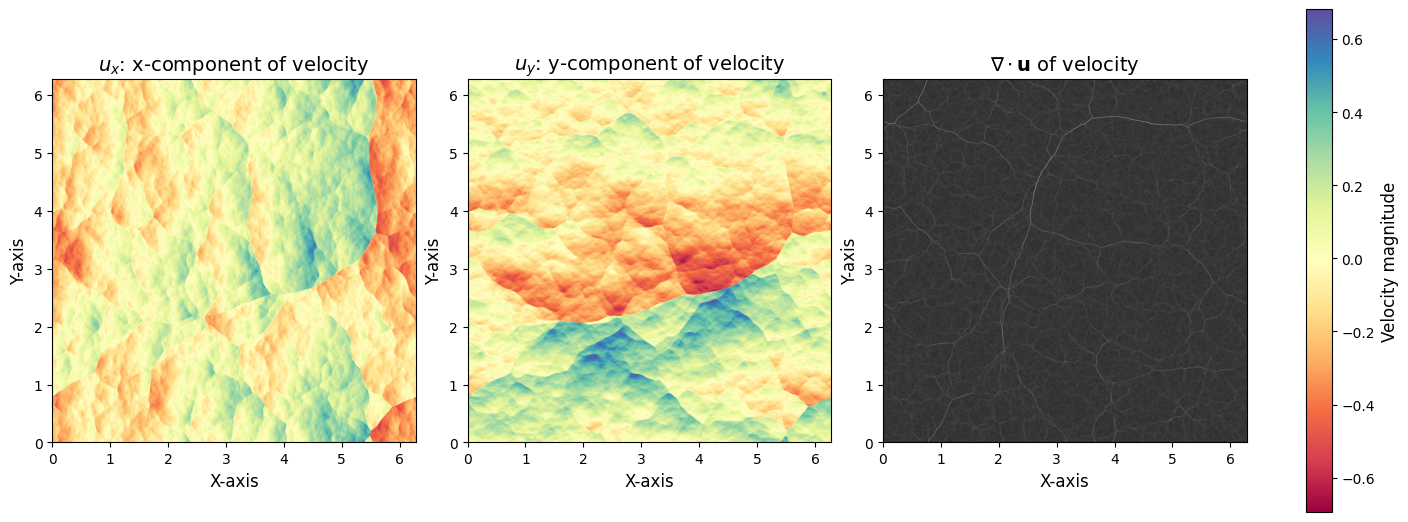

In [ ]:
####################################################################################
'''
Visualization of Final condition
'''
####################################################################################
final_vel = jnp.load(os.path.join(folder_path, f'Velocity_Particle_Data_{239}.npz'))['v_spec']

u_x = jnp.fft.irfft2(final_vel[0], norm='ortho')
u_y = jnp.fft.irfft2(final_vel[1], norm='ortho')

vmin = min(u_x.min(), u_y.min())
vmax = max(u_x.max(), u_y.max())

f, axarr = plt.subplots(1, 3, figsize=(14, 6), constrained_layout=True)

im0 = axarr[0].imshow(u_x.T, origin='lower', extent=[0, L, 0, L],
                      cmap='Spectral', vmin=vmin, vmax=vmax)
axarr[0].grid(False)

im1 = axarr[1].imshow(u_y.T, origin='lower', extent=[0, L, 0, L],
                      cmap='Spectral', vmin=vmin, vmax=vmax)

axarr[1].grid(False)

im2 = axarr[2].imshow( jnp.fft.irfft2(jnp.sum(derivative_operator*final_vel,0)) , origin='lower', extent=[0, L, 0, L],
                      cmap='Grays')

axarr[2].grid(False)

axarr[0].set_title(r'$u_x$: x-component of velocity', fontsize=14)
axarr[1].set_title(r'$u_y$: y-component of velocity', fontsize=14)
axarr[2].set_title(r'$\nabla \cdot \mathbf{u}$ of velocity', fontsize=14)

for ax in axarr:
    ax.set_xlabel("X-axis", fontsize=12)
    ax.set_ylabel("Y-axis", fontsize=12)

cbar = f.colorbar(im1, ax=axarr, shrink=0.85, location='right')
cbar.set_label("Velocity magnitude", fontsize=12)
plt.savefig('velocity_fields_div_fields')

plt.show()

In [ ]:
####################################################################################
'''
Function calculating Energy Spectra
'''
####################################################################################

def Energy_spectra(x):
    return np.histogram(jnp.sqrt(-laplacian).ravel(),bins = shells,weights=x.ravel())[0]

In [ ]:
####################################################################################
'''
calculating Averaged Energy Spectra for a given set of velocity field snapshots.
'''
####################################################################################

spectrum = jnp.zeros(len(shells)-1)

init = 250  # Initial snapshot number

final = 450  # Final snapshot number

skip = 10

for i in tqdm(range(init, final )):

  u_dummy = jnp.load(os.path.join(folder_path, f'Velocity_Particle_Data_{i}.npz'))['v_spec']

  spectrum += (1/N**2)*Energy_spectra(0.5*jnp.sum(jnp.abs(u_dummy)**2,0))

spectrum = skip*(spectrum/(final-init+1))       # Dividing by the proper factor

100%|██████████| 200/200 [05:11<00:00,  1.56s/it]


In [ ]:
jnp.savez(os.path.join(folder_path, f'Energy_spectrum.npz'), E_k = spectrum)

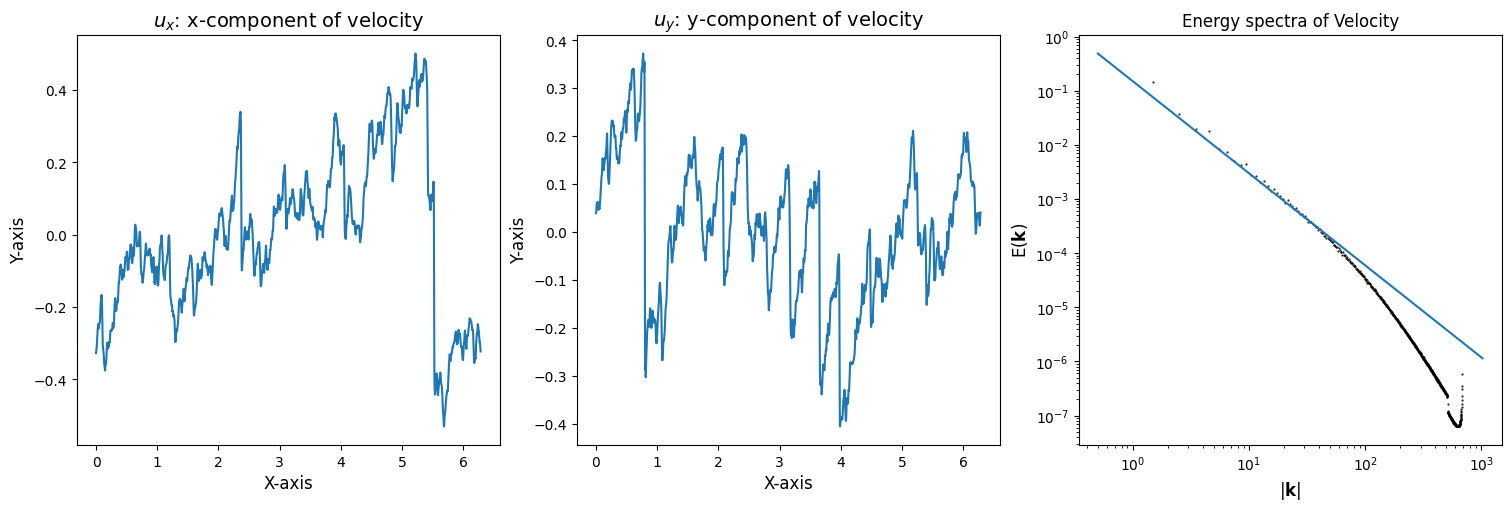

In [ ]:
####################################################################################
'''
Visualization of Final condition And Energy Spectra
'''
####################################################################################

u_x = jnp.fft.irfft2(final_vel[0], norm='ortho')
u_y = jnp.fft.irfft2(final_vel[1], norm='ortho')



f, axarr = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)



im0 = axarr[0].plot(linear_array ,u_x[:,10], ms = 0.5)
im1 = axarr[1].plot(linear_array ,u_y[10,:], ms = 0.5)
im2 = axarr[2].loglog(shells[1:],spectrum ,'o', ms = 0.5 ,  color = 'black')
im2 = axarr[2].loglog(shells,1.5e-1*shells**(-2+0.3))

# axarr[2].set_ylim(1e-10,1e0)


axarr[0].set_title(r'$u_x$: x-component of velocity', fontsize=14)
axarr[1].set_title(r'$u_y$: y-component of velocity', fontsize=14)

for ax in axarr:
    ax.set_xlabel("X-axis", fontsize=12)
    ax.set_ylabel("Y-axis", fontsize=12)


axarr[2].set_xlabel(r"|$\mathbf{k}$|", fontsize=12)
axarr[2].set_ylabel(r"E($\mathbf{k}$)", fontsize=12)
axarr[2].set_title(r"Energy spectra of Velocity", fontsize=12)
cbar.set_label("Velocity magnitude", fontsize=12)


axarr[0].grid(False)
axarr[1].grid(False)
axarr[2].grid(False)

plt.savefig('cross_velocity_fields_Energy_spectra')

plt.show()

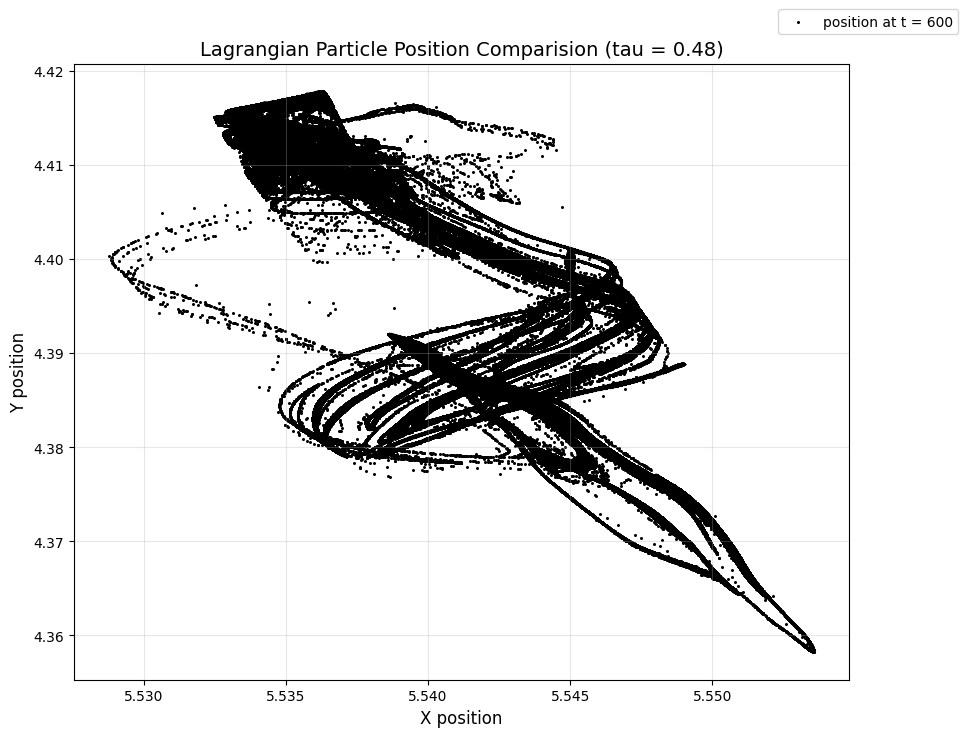

In [ ]:
plt.figure(figsize=(10, 8))

Inital_pos_particle = (jnp.load(os.path.join(folder_path, f'Velocity_Particle_Data_{0}.npz'))['pos_particle'])
Final_pos_particle = (jnp.load(os.path.join(folder_path, f'Velocity_Particle_Data_{239}.npz'))['pos_particle'])


plt.scatter(jnp.array(Final_pos_particle)[2,:,0], jnp.array(Final_pos_particle)[2,:,1], color = 'black', label = 'position at t = 600', s = 1.4)



plt.xlabel('X position', fontsize=12)
plt.ylabel('Y position', fontsize=12)
plt.title(f'Lagrangian Particle Position Comparision (tau = {tau_p[2]})', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.legend()
plt.legend(bbox_to_anchor=(1.15, 1.1), ncol=3)
plt.savefig('particle_trajectory.png', dpi=150, bbox_inches='tight')
plt.show()


# Stationary State Statistics: 1. Energy 2. Dissipaation 3. $\eta$  4. $\tau_\eta$

In [ ]:
E = jnp.zeros(500)
dissp = jnp.zeros(500)

counter = 0

for i in tqdm(range(0,500)):

  dumm = (jnp.load(os.path.join(folder_path, f'Velocity_Particle_Data_{counter}.npz'))['v_spec'])

  E = E.at[counter].set(jnp.sum(jnp.abs(dumm)**2))

  dissp_dumm = jnp.sum(jnp.fft.irfft2(k_vec[0]*dumm[0], norm = 'ortho')**2) +  jnp.sum(jnp.fft.irfft2(k_vec[0]*dumm[1], norm = 'ortho')**2)  +jnp.sum(jnp.fft.irfft2(k_vec[1]*dumm[0], norm = 'ortho')**2)  + jnp.sum(jnp.fft.irfft2(k_vec[1]*dumm[1], norm = 'ortho')**2)
  dissp = dissp.at[counter].set(nu*dissp_dumm)

  counter +=1

E = E/N**2
dissp = dissp/N**2
tau_eta = (nu/dissp)**(0.5)

100%|██████████| 500/500 [12:26<00:00,  1.49s/it]


In [ ]:
jnp.savez(os.path.join(folder_path, f'Energy_vs_time.npz'), E_t = E)
jnp.savez(os.path.join(folder_path, f'Energy_dissp_vs_time.npz'), dissp_t = dissp)

In [ ]:
E = jnp.load(os.path.join(folder_path, f'Energy_vs_time.npz'), allow_pickle=True)['E_t']
dissp = jnp.load(os.path.join(folder_path, f'Energy_dissp_vs_time.npz'), allow_pickle=True)['dissp_t']

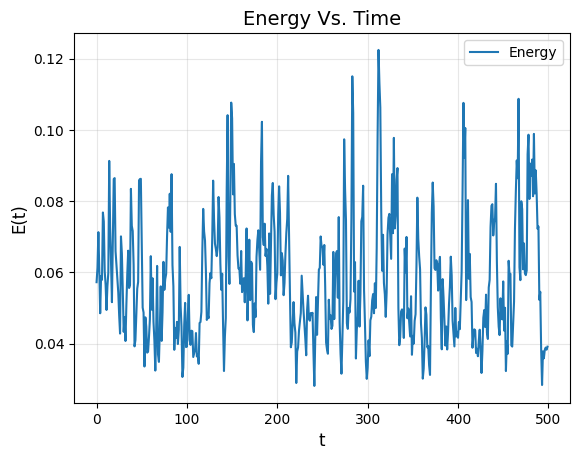

In [ ]:
plt.plot(np.arange(0,500),E, label = 'Energy')

plt.xlabel('t', fontsize=12)
plt.ylabel('E(t)', fontsize=12)
plt.title(f'Energy Vs. Time', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

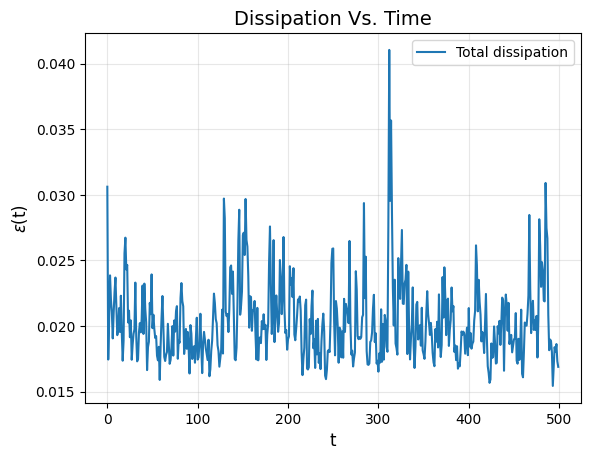

In [ ]:
plt.plot(np.arange(0,500),dissp, label = 'Total dissipation')

plt.xlabel('t', fontsize=12)
plt.ylabel(r'$\epsilon$(t)', fontsize=12)
plt.title(f'Dissipation Vs. Time', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Mean Tau_eta: 0.157966211344
Root Mean Tau_eta: 0.00010815468019176219


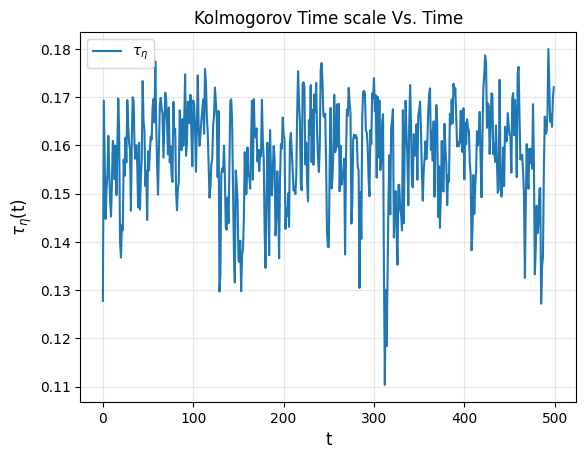

In [ ]:
tau_eta = (nu/dissp)**(0.5)

plt.plot(np.arange(0,500), tau_eta, label = r'$\tau_\eta$')

plt.xlabel('t', fontsize=12)
plt.ylabel(r'$\tau_\eta$(t)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.title("Kolmogorov Time scale Vs. Time")
print('Mean Tau_eta:', jnp.mean(tau_eta) )
print('Root Mean Tau_eta:', jnp.mean((tau_eta - jnp.mean(tau_eta))**2) )

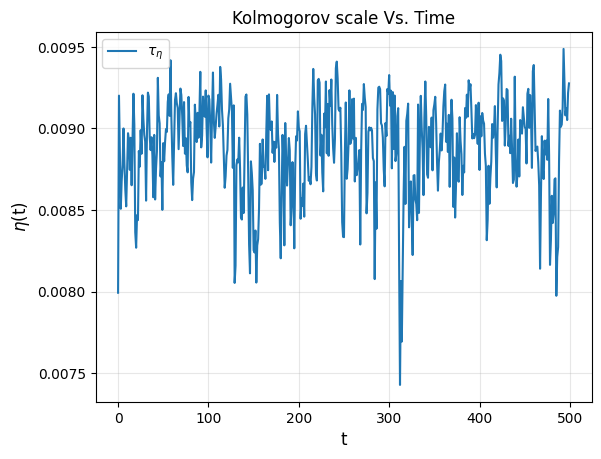

In [ ]:
eta = (nu**3/dissp)**(0.25)

plt.plot(np.arange(0,500), eta, label = r'$\tau_\eta$')

plt.xlabel('t', fontsize=12)
plt.ylabel(r'$\eta$(t)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.title("Kolmogorov scale Vs. Time");

In [ ]:
from google.colab import runtime
runtime.unassign()